In [1]:
__author__ = 'Stephanie Juneau <stephanie.juneau@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu>, Knut Olsen <knut.olsen@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20230728' # yyyymmdd
__datasets__ = ['ls_dr9', 'ls_dr3', 'sdss_dr13']
__keywords__ = ['science example', 'galaxies', 'object classification', 'plot:color-color', 'stars', 'image cutout', 'sia']

# Star/Galaxy/QSO Classification in the DESI Imaging Legacy Surveys
by Stéphanie Juneau, Robert Nikutta, Knut Olsen, and the Astro Data Lab Team

### Table of contents
* [Goals & summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Introduction](#introduction)
* [Imports & setup](#import)
* [Query DECaLS Tractor photometry catalog](#query)
* [Plot results](#plots)
* [Full size LS DR3 query](#fullsize)
* [User contributions](#users)
* [Image cutouts for subsets of objects](#cutouts)

<a class="anchor" id="goals"></a>
# Goals
* Optical and infrared colors from DESI imaging Tractor catalogs
* Classify objects likely to be stars, galaxies or QSOs

# Summary
In this notebook, we investigate the optical and infrared colors of astronomical sources detected in the DESI imaging Legacy Surveys (LS). The ninth data release of this imaging survey comprises ~2 billion stars, galaxies and quasars (or QSOs: Quasi-Stellar Objects). 

Astro Data Lab products and services used here:
* The Legacy Surveys (LS) DR9 database
* Jupyter notebook server
* Query Manager
* Image cutout tool similar to Data Lab SIA

Below, we query the database, compute colors, plot a few color combinations, and take into account the source "type" as defined from the light profile shape in order to differentiate between object classes.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab Acknowledgement: https://datalab.noirlab.edu/acknowledgements.php

Depending on your useage, you can optionally consider to read/acknowledge the following:

* "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms": Juneau et al. 2021, https://ui.adsabs.harvard.edu/abs/2021CSE....23b..15J/abstract

Using the Data Lab platform is subject to these disclaimers: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="introduction"></a>
# Introduction

*Ellipticals are red; Spirals are blue.*

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxies, and background galaxies at various distances, including QSOs with actively accreting supermassive black holes.

<figure>
<img src="DECaLS_noLabels.jpg", align="center", width=700>
    <figcaption><b>Figure 1.</b> Small section of the <i>grz</i> color image from the Legacy Surveys Viewer (http://legacysurvey.org/viewer) around RA=253.3, Dec=29.2 degrees.</figcaption>
</figure>


In preparation for DESI ([Dark Energy Spectroscopic Experiment](http://desi.lbl.gov)), the imaging Legacy Surveys (including DECaLS) will be used to select over 30 million targets for the spectroscopy campain. The main DESI sample will comprise emission-line galaxies (ELGs), luminous red galaxies (LRGs), and QSOs. There will also be a Bright Galaxy Survey (BGS) targetting a magnitude-limited sample (*r*<19.5), including stars within the Milky Way.

<figure>
<img src="DECaLS_Labels.jpg", align="center", width=700>
<figcaption><b>Figure 2.</b> Same section of the LS image as in Figure 1 but with labels from a preliminary target selection algorithm (applied to early DR2 observations).</figcaption>
</figure>

## Information about the Legacy Surveys
LS covers ~19,000 deg² in the *g, r, z* bands to depths of *g*=24.7, *r*=23.9, *z*=23.0. Infrared WISE data are also extracted at the location of the LS sources. The ninth data release (DR9) covers the entire footprint: DECaLS data over the Sourthern portion; MzLS and BASS data covering the northern portion of the Legacy Surveys imaging footprint.

You can read more about LS on the Data Lab survey page [(here)](https://datalab.noirlab.edu/ls/ls.php) and on the Legacy Surveys team website [(here)](http://legacysurvey.org). 

## Magnitudes and colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. In this work, we use:

* *g,r,z* from the Dark Energy Camera (DECam)
* *W1, W2* forced photometry in [WISE](http://www.nasa.gov/mission_pages/WISE/main/) channels 1 & 2 (3.4 and 4.6 microns)

Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighter in the bluer (i.e., shorter wavelength) band. 

We will use the following colors: 
* *g-r*
* *r-z*
* *z-W1*
* *W1-W2*

## Object shapes/types

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for LS DR9:
* PSF (point spread function: size will vary with the seeing of the observations)
* REX (round exponential profile; round spiral galaxies)
* EXP (exponential profile; spiral galaxies)
* DEV (deVaucouleurs profile; elliptical galaxies)
* SER (Sersic profile)
* DUP (Duplicate type for Gaia sources that are part of an extended source in Tractor -- assigned zero flux)

<figure>
<img src="Gals_Qso.jpg", align="left", width=600>
<figcaption><b>Figure 3.</b> Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

Summary of shape fitting and assignment:
<ol>
<li>Fit all sources with PSF and REX; keep if significant (5 sigma); otherwise discard.
<li>If REX is better model, fit again with EXP and DEV; keep if 3 sigma improvement
<li>Fit again with SER (Sersic profile; keep if further 3 sigma improvement
</ol>

Please note that the **SER** (Sersic) type was newly introduced in DR9. In DR8 previous releases included a **COMP** (Composite) type for objects with both an exponential and deVaucouleurs components to their total profile. Prior to DR4, the **SIMP** model was used instead of the current **REX** (Round Exponential).

<a class="anchor" id="import"></a>
# Imports & setup

In [2]:
# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
%matplotlib inline

# Data Lab
from dl import queryClient as qc

<a class="anchor" id="query"></a>
# Query LS DR9 Tractor photometry catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as aperture photometry in various aperture sizes. In this work, we will use Tractor model magnitudes.

The database is called **ls_dr9** and includes several tables. We will use the **tractor** table, selected to contain primary objects over the entire footprint (as a note, **tractor_n** and **tractor_s** cover the North and South footprint, respectively). The column names and descriptions can be found from the [Data Lab Query Interface](https://datalab.noirlab.edu/query.php?name=ls_dr9.tractor) or using the Table Access Protocol (TAP) service with, e.g., TOPCAT. In both cases, we are interested in **ls_dr9.tractor**.

In [3]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
               dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
               snr_g, snr_r, snr_z, snr_w1, snr_w2, ra, dec 
        FROM ls_dr9.tractor
        WHERE (snr_g>5 and snr_r>5 and snr_z>5 and snr_w1>5 and snr_w2>5 and random_id<0.1)
        LIMIT 400000"""
 
# dered_mag_g,r,z  = AB magnitudes in DECam g,r,z bands corrected for Galactic reddening
# dered_mag_w1,w2  = AB magnitudes in WISE bands W1 & W2 corrected for Galactic reddening
# type             = object type (PSF, SIMP, EXP, DEV, COMP)
# snr_g,r,z        = pre-computed signal-to-noise ratios (S/N) in g,r,z bands
# snr_w1,w2        = pre-computed signal-to-noise ratios (S/N) in W1 & W2 bands
# ra,dec           = celestial coordinates
# random_id        = random ID (0-100) to select a small fraction objects randomly distributed on the sky
#
# WHERE: requirement that S/N>5 in each LS band
# LIMIT: returns 400,000 rows that satisfy the query (takes 7.5 sec w/ normal server load)

print(query)


        SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
               dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
               snr_g, snr_r, snr_z, snr_w1, snr_w2, ra, dec 
        FROM ls_dr9.tractor
        WHERE (snr_g>5 and snr_r>5 and snr_z>5 and snr_w1>5 and snr_w2>5 and random_id<0.1)
        LIMIT 400000


In [4]:
%%time
# Execute the Query synchronously if short (e.g., LIMIT<=400,000)
result = qc.query(sql=query, fmt='pandas')

# Optionally, save output to myDB (uncomment below and comment above BEFORE executing the cell)
#tmp = qc.query(sql=query, out='mydb://lsdr9_random0p1', drop=True)

# If longer query, can run asynchronously (see How_to_use_the_queryClient Notebook)

CPU times: user 965 ms, sys: 455 ms, total: 1.42 s
Wall time: 1min 15s


In [5]:
# If saved to mydb, can query the table
#result = qc.query(sql="SELECT * FROM mydb://lsdr9_random0p1", fmt='pandas')

In [6]:
# Print a few rows from the result (pandas DataFrame)
print(len(result))
print(result[:5])

268005
        gmag       rmag       zmag      w1mag      w2mag type        snr_g  \
0  23.044521  21.341413  20.615875  20.024673  20.628265  DEV    17.896101   
1  15.763890  15.097550  14.893347  16.105503  16.806711  PSF  1283.366700   
2  19.106127  17.751947  16.931606  17.608112  18.223060  PSF   487.070680   
3  15.658857  15.202118  15.095008  16.512575  17.174395  PSF  2558.850000   
4  22.515300  21.080187  20.296516  19.756900  19.975266  REX    25.293540   

         snr_r        snr_z      snr_w1      snr_w2          ra        dec  
0    48.675056    55.289436   18.349790    5.133045   73.845016  -8.516546  
1   617.863160   351.374180  297.433840  113.184044  155.422672 -30.047779  
2   822.325100   999.688230  119.268425   36.151608  188.249308  -7.802713  
3  3599.872600  2017.284900  261.863160   97.214570  351.941695  31.012169  
4    53.934814    47.962627   22.168630    8.784081  188.717069  29.662096  


<a class="anchor" id="vars"></a>
# Define useful variables

In [7]:
# Colors
g_r   = result['gmag'] - result['rmag']
r_z   = result['rmag'] - result['zmag']
z_w1  = result['zmag'] - result['w1mag']
w1_w2 = result['w1mag'] - result['w2mag']

# Classification per object type
objtype = result['type']

# List of object types (ignoring DUP, which have zero fluxes)
typeList = ['All','PSF','REX','EXP','DEV','SER']

<a class="anchor" id="plots"></a>
# Plot results

## Optical color-color diagram

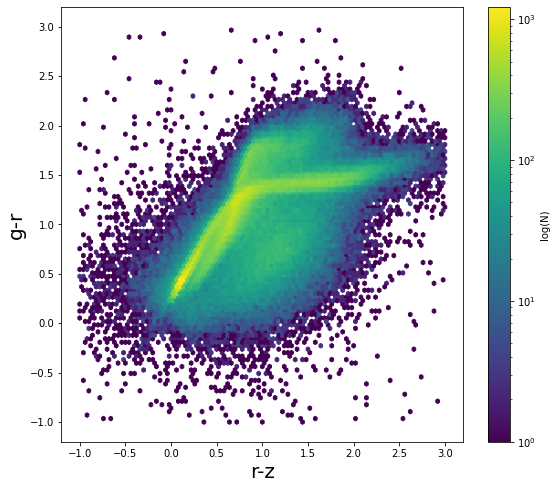

In [8]:
#r-z vs. g-r colors

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(r_z, g_r, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_xlabel('r-z',fontsize=20)
ax1.set_ylabel('g-r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

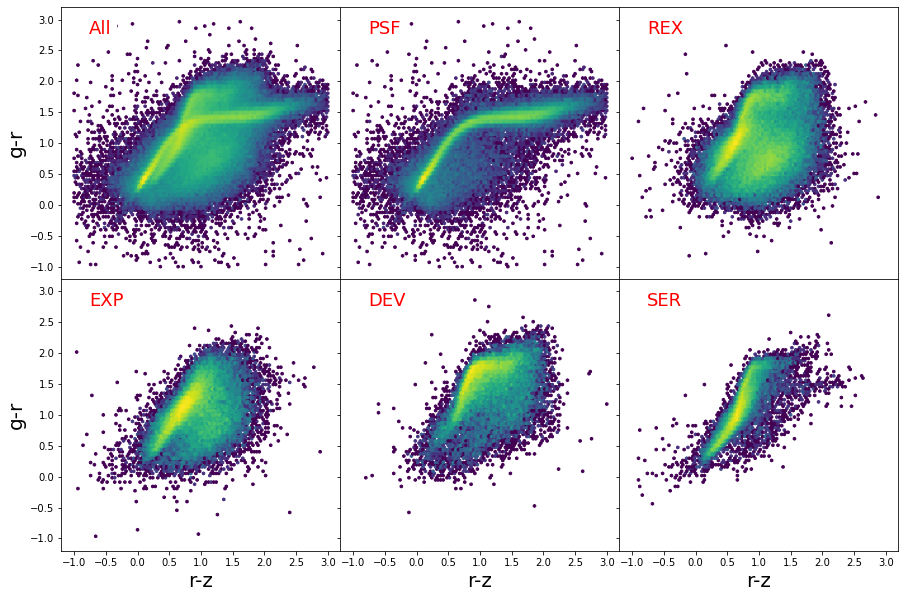

In [9]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# Define figure to have 6 panels: 2 rows X 3 columns (with shared axes)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()   # flatten axes object to be able to loop over it

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(col0),dtype='bool')   #for All objects: array of 1's
    else:
        selec = (objtype==typ)    #for each type, select on the type parameter
    # 2D-histogram of objects with hexagonal bins
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
    if i>=3: ax.set_xlabel('r-z',fontsize=20)   #only label x axis for second (last) row
    if i%3==0: ax.set_ylabel('g-r',fontsize=20) #only label y axis for first column
    # Label the type on each panel (red font over white background)
    ax.text(0.1,0.9,typ,transform=ax.transAxes,fontsize=18,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0., hspace=0.)

plt.show()

## Optical-infrared colors

Combine information from optical/near-infrared DECaLS/BASS/MzLS observations and from WISE mid-infrared observations. The latter were extracted using "forced photometry" at the position of LS objects.

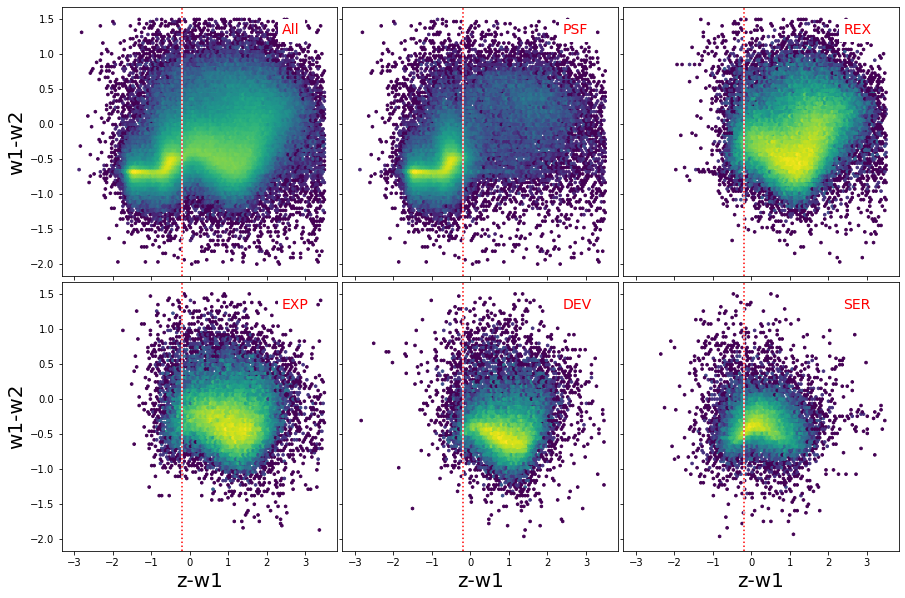

In [10]:
# First, try z-W1 versus infrared color W1-W2
col0 = z_w1
col1 = w1_w2

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')
    else:
        selec = (objtype==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3.5, -2., 1.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('w1-w2',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')
    ax.axvline(-0.2,color='w',ls='-')
    ax.axvline(-0.2,color='r',ls=':')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

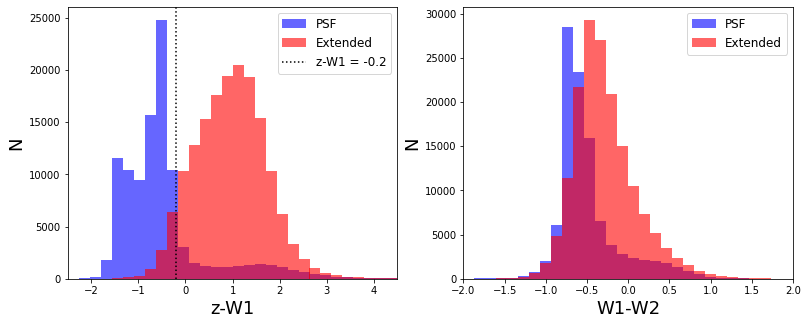

In [11]:
is_psf = (objtype=='PSF')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes = axes.flatten()

colors = [z_w1, w1_w2]
colnames = ['z-W1', 'W1-W2']
xlims = [[-2.5,4.5],[-2.,2.]]

for i,col in enumerate(colors):
    ax = axes[i]
    ax.hist(col[is_psf], 30, range=xlims[i], color='b', alpha=0.6, label='PSF')
    ax.hist(col[~is_psf], 30, range=xlims[i], color='r', alpha=0.6, label='Extended')
    ax.set_xlabel(colnames[i],fontsize=18)
    ax.set_ylabel('N',fontsize=18)
    ax.set_xlim(xlims[i])
    if i==0: ax.axvline(-0.2, ls=':', color='k', label='z-W1 = -0.2')
    ax.legend(fontsize=12)

### Notes:

In the figures above, we can see that the *z-W1* color has much more separating power between point sources (PSF) and the extended objects (galaxies with type REX, EXP, DEV or SER). Namely, the majority of objects with type=PSF have *z-W1*<-0.2 (vertical dotted line). Conversely, the majority of extended galaxies have *z-W1* >-0.2 (vertical dotted line). However, these different categories overlap more strongly in their *W1-W2* colors. Next, we will make a combination of the optical color *g-r* with the near-IR/mid-IR color *z-W1* to aim for a better Star-Galaxy separation.

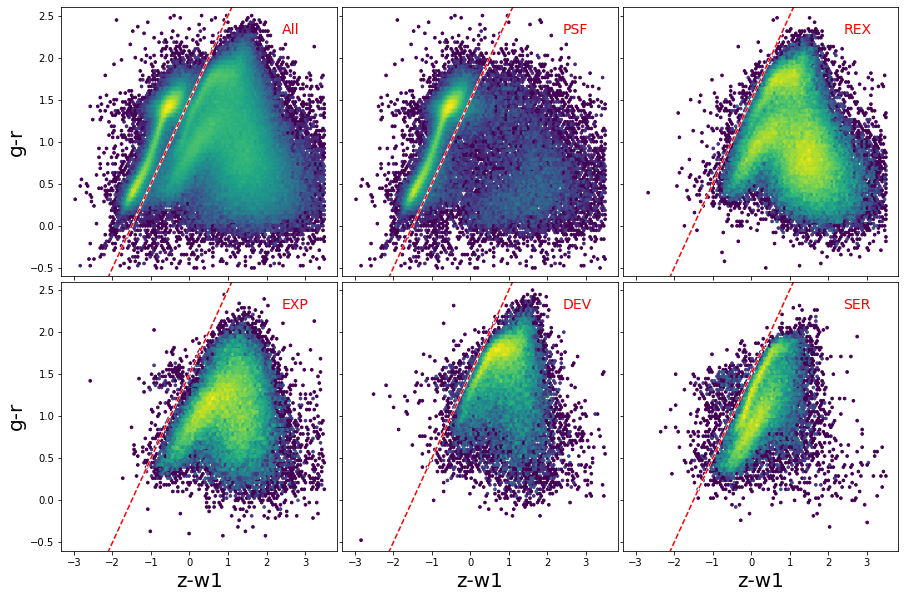

In [12]:
# Combine g-r with z-W1 color (latter has more separation power than W1-W2)
col0 = z_w1
col1 = g_r

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

x = np.arange(-2.3,2.3,0.05)

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')
    else:
        selec = (objtype==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3.5, -0.5, 2.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('g-r',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')
    ax.plot(x, 1.0*x+1.5, '-',lw=2,color='w')
    ax.plot(x, 1.0*x+1.5, '--',color='red')
    ax.set_ylim(-0.6,2.6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

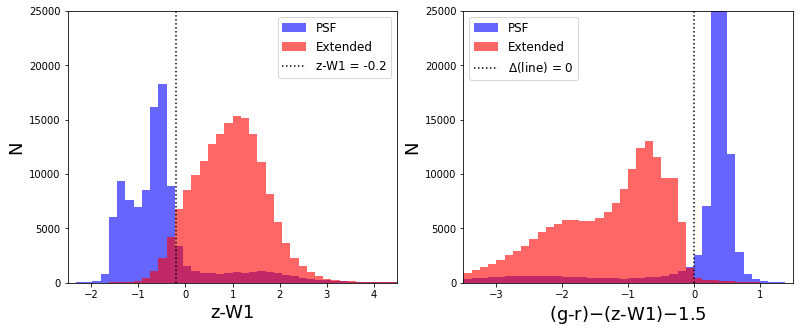

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes = axes.flatten()

#g_r_line = 1.0*z_w1+1.6

colors = [z_w1, g_r-z_w1-1.5]
colnames = ['z-W1', '(g-r)$-$(z-W1)$-$1.5']
xlims = [[-2.5,4.5],[-3.5,1.5]]

for i,col in enumerate(colors):
    ax = axes[i]
    ax.hist(col[is_psf], 40, range=xlims[i], color='b', alpha=0.6, label='PSF')
    ax.hist(col[~is_psf], 40, range=xlims[i], color='r', alpha=0.6, label='Extended')
    ax.set_xlabel(colnames[i],fontsize=18)
    ax.set_ylabel('N',fontsize=18)
    ax.set_xlim(xlims[i])
    ax.set_ylim(0,2.5e4)    ## Comment out this y-range limit to see the full histograms
    if i==0: ax.axvline(-0.2, ls=':', color='k', label='z-W1 = -0.2')
    if i==1: ax.axvline(0., ls=':', color='k', label='$\Delta$(line) = 0')
    ax.legend(fontsize=12)

### Notes:
As we had hoped, this color combination achieves a better separation between point sources (mostly stars but possibly some QSOs) and extended objects (galaxies). The red line is drawn empirically to help guide the eye. We can see that the vast majority of point sources (PSF) lie to the left of the line. Conversely, the vast majority of extended objects (galaxies with type REX, EXP, DEV or SER) lie to the right of the line. Interestingly, there is also noticeable structure as part of the bivariate distributions with ridge-like features oriented roughly parallel with the dashed line and a broad cloud of points toward the reddest *z-W1* colors. Further investigations are left for the reader, except that we will show how to retrieve color and WISE image cutouts for PSF objects on the blue vs. red side of the dashed line in the section called: [Image cutouts for subsets of objects](#cutouts).

<a class="anchor" id="fullsize"></a>
# Full size LS DR3 query

Below is the result from the query *without* a LIMIT statement made directly to the database (it takes an hour to return the full result with over 151 million rows). The query run was:

```SQL
query = """SELECT dered_mag_g as gmag, dered_mag_r as rmag, dered_mag_z as zmag, 
                  dered_mag_w1 as w1mag, dered_mag_w2 as w2mag, type,
                  snr_g, snr_r, snr_z, ra, dec 
           FROM ls_dr3.tractor_primary
           WHERE (snr_g>3 and snr_r>3 and snr_z>3)"""
```
        
For the first plot, we require a threshold **S/N>10 for *z*, *W1*, *W2***. The result is shown for 15 million objects satisfying these criteria (out of 151 millions). 
<figure>
<img src="grzw1_sn10_15M.jpg", align="center", width=800>
<figcaption><b>Figure:</b> Optical-Infrared Color-Color diagram showing million objects with S/N>10 in <i>z, W1, W2</i> (in addition to the requirement that S/N>3 for <i>g, r</i>). </figcaption>
</figure>
 
Next, we request that **S/N>3 in *z*, *W1* & *W2* but S/N<10 in at least one band**. This new condition is met for 29 million objects, which we show below.

<figure>
<img src="grzw1_3sn10_29M.jpg", align="center", width=800>
<figcaption><b>Figure:</b> Optical-Infrared Color-Color diagram showing million objects with S/N>10 in <i>z, W1, W2</i> (in addition to the requirement that S/N>3 for <i>g, r</i>). The vertical plotting range extends down to -1 (whereas it was set to -0.5 in the previous figure). </figcaption>
</figure>

The top figure with a strict quality requirement (S/N>10) shows well defined features such as branches and ridges in the color-color planes. However, the bivariate distributions are more blurry in the bottom figure. 

<a class="anchor" id="users"></a>
# User contributions

Inpired from this notebook, a few users have pushed the analysis further. Below, we will show two such contributions by graduate students during Hack sessions. First, here is an example of work with multi-epoch photometry by Dustin Lang.

## Adding variability information
Photometry variability can add information given that QSOs, galaxies and stars have different behavior. Some of the Data Lab databases include multi-epoch photometry (such as the [NOIRLab Source Catalog](https://datalab.noirlab.edu/nscdr2/index.php)). The Legacy Surveys includes multiple epochs of WISE photometry but not yet multiple epochs in the optical/near-infrared bands.

Images from DECam in the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/) can be extracted in fields with repeat observations such as DES Supernova fields overlapping with DECaLS.

<figure>
<img src="time_series_2a.png", align="center", width=800>
<figcaption><b>Figure:</b> Magnitudes in three bands as a function of time for a known SDSS quasar. Courtesy of Dustin Lang (Univ. of Toronto).  </figcaption>
</figure>

## Adding spectroscopic information from SDSS
There is a Legacy Surveys DR3 catalog pre-matched to SDSS DR13 spectroscopy [ls_dr3.dr3_specobj_dr13](https://datalab.noirlab.edu/query.php?name=ls_dr3.dr3_specobj_dr13). One can execute a joint query by joining on "specobjid" with SDSS DR13 [(sdss_dr13.specobj)](https://datalab.noirlab.edu/query.php?name=sdss_dr13.specobj). Bela Abolfathi (UC Irvine) started this work as part of a Hack Session with LSSTC Data Science Fellowship.


<figure>
<img src="hack1.jpg", align="center", width=900>
<figcaption><b>Figure:</b> Color-color diagrams of DECaLS photometry split by SDSS spectral classes. Slightly modified version of figure by Bela Abolfathi (UC Irvine). </figcaption>
</figure>


## Machine Learning application

A training set was built using DECaLS DR3 photometry and SDSS (DR13 & DR12Q) classifications. This preliminary work was done by Jan-Torge Schindler (Univ. of Arizona). Updates could include using more parameters beyond photometry (e.g., type, chi^2).

<figure>
<img src="hack2.jpg", align="center", width=500>
<figcaption><b>Figure:</b> Confusion Matrix comparing true classification from SDSS and the result from the Random Forest classification. Courtesy of JT Schindler (Univ. of Arizona). </figcaption>
</figure>

For an example application of Random Forest for Star/Galaxy classification applied to the Palomar Transient Factory (PTF) survey, see [Miller et al (2017)](http://adsabs.harvard.edu/abs/2017AJ....153...73M).

<a class="anchor" id="cutouts"></a>
# Image cutouts for subsets of objects

The NOIRLab Astro Data Lab has developed a Simple Image Access (SIA) tool, which returns the list of possible images given a location (RA, Dec). Below, we use an image cutout service at NERSC to retrieve *g,r,z* and *W1,W2* color jpeg images.

We will get imagse for objects with "type=PSF", and randomly select six with a blue *z-W1* color expected for the stellar locus, and six with a red *z-W1* color corresponding the cloud of points to the right-hand side of the color-color diagrams from the previous section. 

## Select subsets and define variables

In [14]:
# Properties for selecting subsamples of interest
objtype = result['type'].values    # ".values" convert to numpy array
col1 = z_w1.values
w1   = result['w1mag'].values
zmag = result['zmag'].values

# Select interesting subset of points
selec = (objtype=='PSF')&(w1>18)&(w1<19.5) # Point source (type=PSF) & bright W1 (18 < W1[AB] < 19.5)
red   = (col1>1)&(col1<2)                  # red side: 1 < z-W1 < 2
blue  = (col1>-0.8)&(col1<-0.5)            # blue side: -0.8 < z-W1 < -0.5

# Retrieve by position (RA, Dec)
ra  = result['ra'].values
dec = result['dec'].values

idx = np.arange(ra.size)

# Indices fulfilling both criteria
psf_red = idx[selec&red]
psf_blue = idx[selec&blue]

# Random selection
selec_blue = np.random.choice(psf_blue,6,replace=False)
selec_red  = np.random.choice(psf_red,6,replace=False)

# Define RA, Dec on blue & red z-W1 sides
ra_blue  = ra[selec_blue]
dec_blue = dec[selec_blue]
ra_red  = ra[selec_red]
dec_red = dec[selec_red]

# Define z & W1 magnitudes on blue & red z-W1 sides
zmag_blue = zmag[selec_blue]
w1_blue   = w1[selec_blue]
zmag_red  = zmag[selec_red]
w1_red    = w1[selec_red]

## Function to retrieve cutouts

In [15]:
def make_cutout_comparison_table(ra_in, dec_in):
    """
    Obtain DECaLS and WISE color JPEG images from Legacy Surveys team cutout tool at NERSC
    """    
    de_img = []
    wi_img = []
    
    for i in range(len(ra_in)):
        de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=ls-dr9&bands=grz&pixscale=0.2&size=200' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)
        
        wi_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=unwise-neo6&pixscale=0.4&size=100' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
        wi_img.append(img)

    return de_img,wi_img

## Function to generate plots

In [16]:
def plot_de_wi(de_img,wi_img,zmag,w1mag):
    """
    Plot images in two rows with 6 images in each row (Top: DECaLS grz; Bottom: WISE W1/W2)
    Label the z band mag on the top images; Label the W1 mag on the bottom images
    """
    fig = plt.figure(figsize=(12,4))

    for i in range(len(de_img)):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(de_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'z=%.1f'%zmag[i],transform=ax.transAxes,fontsize=12,color='white')

        ax = fig.add_subplot(2,6,i+7)
        ax.imshow(wi_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'W1=%.1f'%w1mag[i],transform=ax.transAxes,fontsize=12,color='white')

    plt.subplots_adjust(wspace=0.02, hspace=0.03)

## Montage for "Blue" *z-W1*

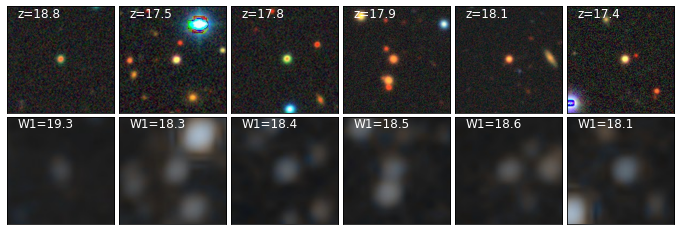

In [17]:
# Plot images of randomly selected targets best fit with a PSF profile
# from the "blue" z-W1 side, with -0.8 < z-W1 < -0.5
de_img,wi_img = make_cutout_comparison_table(ra_blue,dec_blue)
plot_de_wi(de_img,wi_img,zmag_blue,w1_blue)

## Montage for "Red" *z-W1*

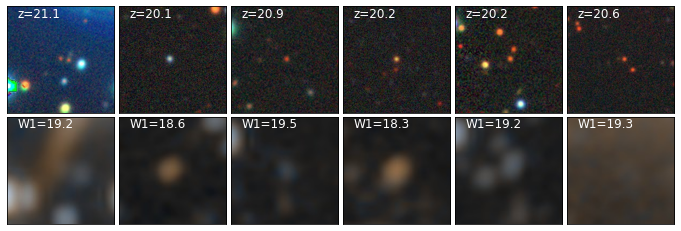

In [18]:
# Plot images of randomly selected targets best fit with a PSF profile 
# from the "red" z-W1 side, with 1 < z-W1 < 2
de_img,wi_img = make_cutout_comparison_table(ra_red,dec_red)
plot_de_wi(de_img,wi_img,zmag_red,w1_red)